# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Notebook written by [Jakob Ambsdorf](mailto:jaam@di.ku.dk).
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fejslngi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fejslngi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=9e42849f9e2d1ed2920def59f5d37451c1d422d704f42a521c07a122c741d171
  Stored in directory: /tmp/pip-ephem-wheel-cache-6vp1oq4y/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-06-14 02:43:03--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# Download model checkpoint
The checkpoint is 2.39GB, takes a few minutes for most bandwidths

In [5]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

sam_vit_h_4b8939.pth: 2.39GB [00:23, 108MB/s]                                   


In [6]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Chest X-ray Dataset

In [7]:
import os
from torchvision.datasets.utils import download_url

In [8]:
# Mount Google drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL')
except:
    print('Google drive not mounted')

Google drive not mounted


In [9]:
# If you are getting a download error, comment in the following lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

100%|██████████| 80938446/80938446 [00:04<00:00, 17665525.24it/s]


In [11]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [12]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

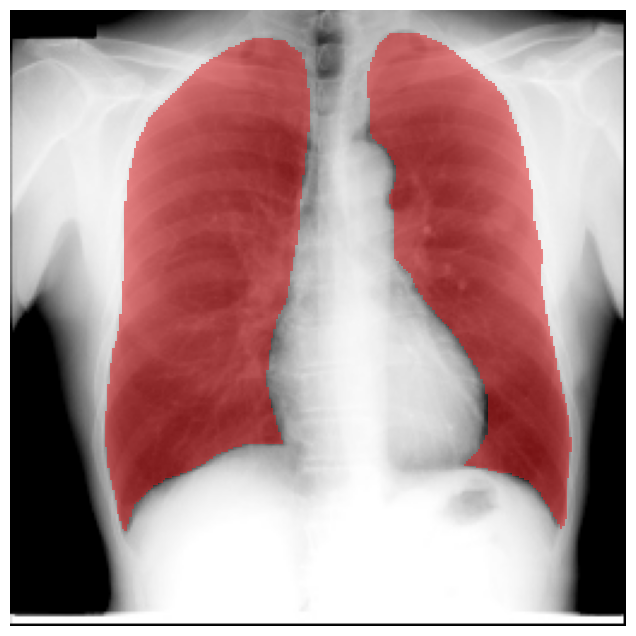

In [13]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

# TODO:
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

# YOUR CODE HERE
# Transform the dataset
def transform_data(x, y):
    # Ensure images have 3 channels by repeating along the last axis
    x_transformed = np.repeat(x, 3, axis=-1)
    # Squeeze the masks to remove the single channel dimension
    y_transformed = np.squeeze(y, axis=-1)
    # Map values to [0, 255]
    x_transformed = map_interval(x_transformed, x_transformed.min(), x_transformed.max(), 0, 255).astype(np.uint8)
    y_transformed = (y_transformed * 255).astype(np.uint8)
    return x_transformed, y_transformed

# def transform_data(x, y):
#     # Ensure images have 3 channels by repeating along the last axis
#     x_transformed = np.repeat(x, 3, axis=-1)
#     # Map values to [0, 255]
#     x_transformed = map_interval(x_transformed, x_transformed.min(), x_transformed.max(), 0, 255).astype(np.uint8)
#     y_transformed = (y * 255).astype(np.uint8).squeeze(axis=-1)
#     return x_transformed, y_transformed

# Apply transformation to the train, validation, and test sets
x_train, y_train = transform_data(x_train, y_train)
x_val, y_val = transform_data(x_val, y_val)
x_test, y_test = transform_data(x_test, y_test)

# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

# Single Example image

Let's try to run SAM on a single example image

In [14]:
example_img, example_mask = x_train[0], y_train[0]

input_points = np.array([[75, 100], [80, 75], [180, 75], [185, 100], [135, 150]]) # TODO: Pick apropriate input points,
input_label = np.array([1, 1, 1, 1, 0]) # TODO: Pick apropriate input labels

example_img.shape

(256, 256, 3)

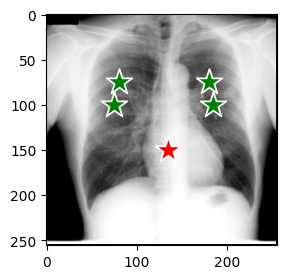

In [15]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca()) # You may also use other prompt methods!
plt.axis('on')
plt.show()

In [16]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

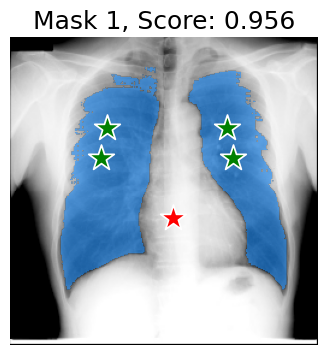

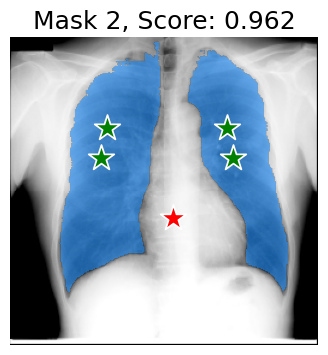

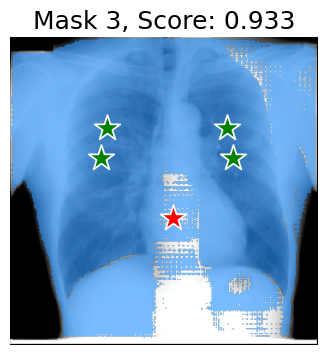

In [17]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Evaluation loop

In [18]:
# example_img, example_mask = x_train[0], y_train[0]

# input_points = np.array([[75, 100], [80, 75], [180, 75], [185, 100], [135, 150]]) # TODO: Pick apropriate input points,
# input_label = np.array([1, 1, 1, 1, 0]) # TODO: Pick apropriate input labels
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

max(scores), min(scores), mask_input, example_img.shape

(0.96194446,
 0.9328892,
 array([[-5.5653763, -5.7948895, -5.3524513, ..., -6.062572 , -5.8109827,
         -6.286517 ],
        [-5.666358 , -5.7120724, -5.5020146, ..., -5.8011575, -5.768153 ,
         -6.050781 ],
        [-5.363158 , -5.788455 , -5.214473 , ..., -5.8954315, -5.532398 ,
         -5.9509106],
        ...,
        [-5.761355 , -5.384341 , -6.0769577, ..., -6.092088 , -5.0376606,
         -5.503269 ],
        [-5.733631 , -5.845459 , -6.2358713, ..., -5.9987965, -4.901316 ,
         -5.3765144],
        [-5.3419394, -5.4805593, -6.165733 , ..., -5.436738 , -4.387383 ,
         -5.0527306]], dtype=float32),
 (256, 256, 3))

In [19]:
masks, _, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [20]:
masks.shape

(1, 256, 256)

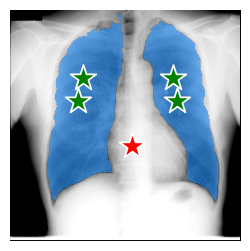

In [21]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_mask(masks, plt.gca())
show_points(input_points, input_label, plt.gca())
# plt.title(f"MaxScore: {max(scores):.3f}", fontsize=18)
plt.axis('off')
plt.show()

In [22]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [23]:
import torchmetrics
f1 = torchmetrics.F1Score(task="binary").to(device)

f1_scores = []
image_num = 0

for img, mask_gt in zip(x_val, y_val):
    # raise NotImplementedError("TODO: Predict segmentation with SAM and compute F1 score.")
    # YOUR CODE HERE
    # Set the image in the predictor
    predictor.set_image(img)

    image_num += 1
    print(f"lung x-ray val No.{image_num}")

    input_points = np.array([[75, 100], [80, 75], [180, 75], [185, 100], [135, 150]]) # TODO: Pick apropriate input points,
    input_label = np.array([1, 1, 1, 1, 0]) # TODO: Pick apropriate input labels

    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        multimask_output=True,
    )
    # for i, (mask, score) in enumerate(zip(masks, scores)):
    #   print(f"Mask {i+1}, Score: {score:.3f}")

    # Choose the model's best mask
    mask_input = logits[np.argmax(scores), :, :]
    print(f"MaxScore: {max(scores):.3f}")


    bestMask, _, _ = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )

    # Get the best mask and normalize it to [0, 1], compute F1 score for the best mask
    best_mask = bestMask[0]
    best_mask = torch.tensor(best_mask, dtype=torch.int).to(device)
    best_mask = (best_mask > 0).int()  # Binarize the predicted mask
    mask_gt = torch.tensor(mask_gt, dtype=torch.int).to(device)
    mask_gt = (mask_gt > 0).int()  # Binarize the ground truth mask

    f1_scores.append(f1(best_mask.flatten(), mask_gt.flatten()).item())

mean_f1 = np.mean(f1_scores) # TODO: Compute mean F1 score
std_f1 = np.std(f1_scores) # TODO: Compute standard deviation of F1 scores

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

lung x-ray val No.1
MaxScore: 0.961
lung x-ray val No.2
MaxScore: 0.972
lung x-ray val No.3
MaxScore: 0.969
lung x-ray val No.4
MaxScore: 0.957
lung x-ray val No.5
MaxScore: 0.965
lung x-ray val No.6
MaxScore: 0.949
lung x-ray val No.7
MaxScore: 0.960
lung x-ray val No.8
MaxScore: 0.969
lung x-ray val No.9
MaxScore: 0.970
lung x-ray val No.10
MaxScore: 0.977
lung x-ray val No.11
MaxScore: 0.953
lung x-ray val No.12
MaxScore: 0.959
Mean F1 score: 0.9084
Standard deviation: 0.0247


Elected example image No.1
Max score with the best mask: 0.961


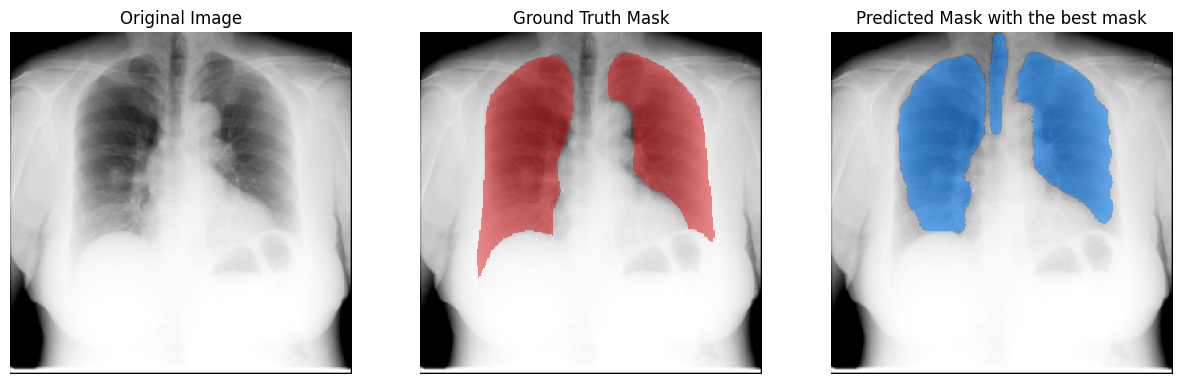

Elected example image No.2
Max score with the best mask: 0.972


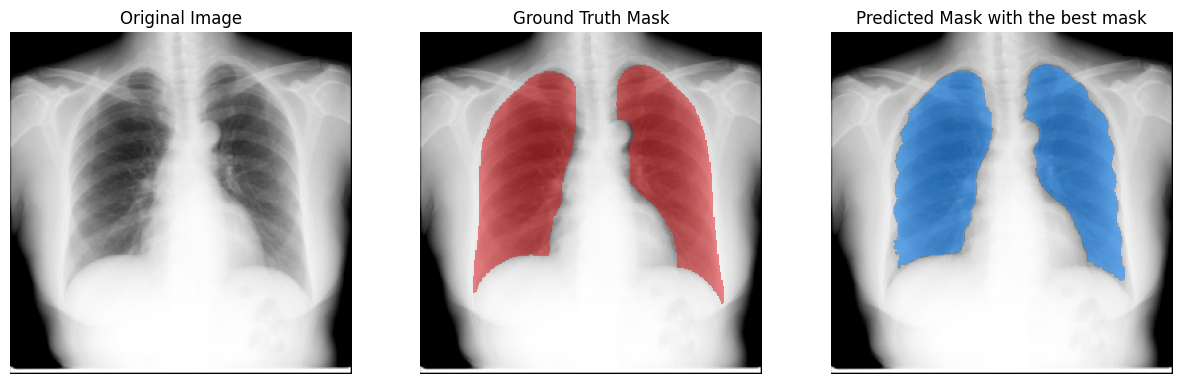

In [24]:
# Function to visualize the original image, the ground truth mask, and the predicted mask
def visualize_results(img, mask_gt, mask_pred, input_points):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img.squeeze(), cmap='gray')
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(img.squeeze(), cmap="gray")
    mask = np.ma.masked_where(mask_gt == 0, mask_gt)
    axs[1].imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis('off')

    axs[2].imshow(img.squeeze(), cmap='gray')
    show_mask(mask_pred, axs[2])
    # show_points(input_points, input_label, axs[2])
    axs[2].set_title("Predicted Mask with the best mask")
    axs[2].axis('off')

    plt.show()

# Select two example images from the validation set
example_indices = [0, 1]  # You can choose any indices from the validation set

for idx in example_indices:
    img = x_val[idx]
    mask_gt = y_val[idx]

    # Set the image in the predictor
    predictor.set_image(img)

    # image_num += 1
    # print(f"Elected example image No.{image_num}")

    print(f"Elected example image No.{idx+1}")

    input_points = np.array([[75, 100], [80, 75], [180, 75], [185, 100], [135, 150]]) # TODO: Pick apropriate input points,
    input_label = np.array([1, 1, 1, 1, 0]) # TODO: Pick apropriate input labels

    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        multimask_output=True,
    )
    # for i, (mask, score) in enumerate(zip(masks, scores)):
    #   print(f"Mask {i+1}, Score: {score:.3f}")

    # Choose the model's best mask
    mask_input = logits[np.argmax(scores), :, :]
    print(f"Max score with the best mask: {max(scores):.3f}")

    bestMask, _, _ = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )

    # Get the best mask and normalize it to [0, 1], compute F1 score for the best mask
    best_mask = bestMask[0]
    best_mask = torch.tensor(best_mask, dtype=torch.int).to(device)
    # Normalize masks to binary values
    best_mask = (best_mask > 0).int().cpu().numpy()
    mask_gt = (torch.tensor(mask_gt, dtype=torch.int).to(device) > 0).int().cpu().numpy()

    # Visualize the results
    visualize_results(img, mask_gt, best_mask, input_points)

# Using Bounding Boxes from GT segmentations as Prompt

Task 5: Generate Bounding Boxes from Ground-Truth Masks

In [25]:
# bounding boxes from segmentation masks
# bonding box format [x0, y0, x1, y1]

# TODO: Implement bounding box extraction from segmentation masks
import cv2
import numpy as np

def get_bounding_boxes(mask):
    """
    Given a binary mask, this function returns bounding boxes for each connected component.
    """
    # Ensure the mask is in the correct format (0 and 255)
    mask = (mask > 0).astype(np.uint8) * 255

    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Generate bounding boxes for each contour
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    # Convert (x, y, w, h) to (x0, y0, x1, y1)
    bounding_boxes = [(x, y, x + w, y + h) for x, y, w, h in bounding_boxes]
    return bounding_boxes

# Apply to the dataset
def generate_bounding_boxes_for_dataset(masks):
    all_bounding_boxes = []
    for mask in masks:
        bounding_boxes = get_bounding_boxes(mask)
        all_bounding_boxes.append(bounding_boxes)
    return all_bounding_boxes

train_bounding_boxes = generate_bounding_boxes_for_dataset(y_train)
val_bounding_boxes = generate_bounding_boxes_for_dataset(y_val)
test_bounding_boxes = generate_bounding_boxes_for_dataset(y_test)

# Verify bounding boxes
print(f"Train bounding boxes: {train_bounding_boxes[0]}")
print(f"Validation bounding boxes: {val_bounding_boxes[0]}")
print(f"Test bounding boxes: {test_bounding_boxes[0]}")


Train bounding boxes: [(39, 11, 125, 218), (148, 8, 234, 217)]
Validation bounding boxes: [(42, 17, 116, 186), (139, 15, 221, 159)]
Test bounding boxes: [(45, 26, 124, 243), (155, 25, 238, 245)]


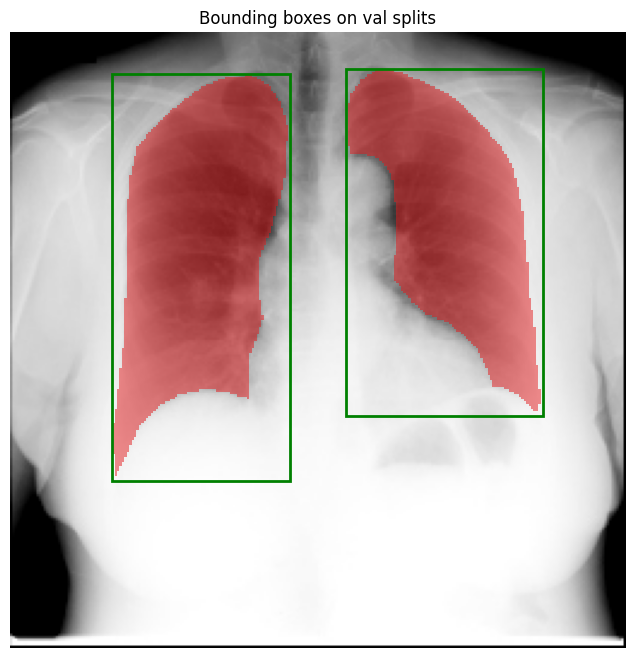

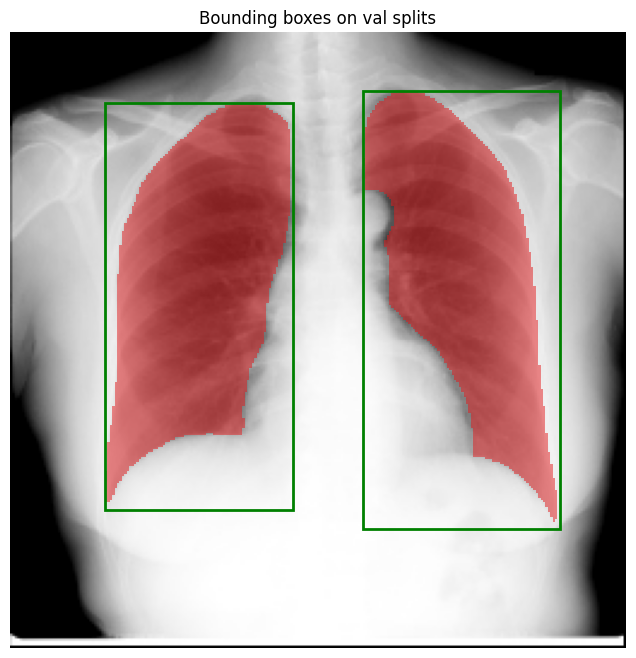

In [71]:
# def show_box(box, ax):
#     x0, y0 = box[0], box[1]
#     w, h = box[2] - box[0], box[3] - box[1]
#     ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

example_indices = [0, 1]
# Generate bounding boxes for two example images
for idx in example_indices:
    img = x_val[idx]
    mask = y_val[idx]
    bounding_boxes = val_bounding_boxes[idx]
    fig, ax = plot_image_with_segmentation(img, mask)
    for box in bounding_boxes:
        show_box(box, ax)
    plt.title("Bounding boxes on val splits")
    plt.axis('off')
    plt.show()

Task 6: Prompt SAM with Bounding Boxes and Compare F1 Scores

In [28]:
import torchmetrics
from scipy import ndimage
import numpy as np
import torch

# Evaluate using bounding boxes
f1 = torchmetrics.F1Score(task="binary").to(device)
f1_scores_bboxes = []

for img, mask_gt, bboxes in zip(x_val, y_val, val_bounding_boxes):
    # Set the image in the predictor
    predictor.set_image(img)

    combined_mask = np.zeros_like(mask_gt, dtype=bool)

    for box in bboxes:
        # Convert the single bounding box to numpy array
        input_box = np.array([box])

        # Predict masks using the bounding box as a prompt
        masks, scores, logits = predictor.predict(
            box=input_box,
            multimask_output=True,
        )

        # Select the best mask and predict again using the logits
        mask_input = logits[np.argmax(scores), :, :]
        masks, _, _ = predictor.predict(
            box=input_box,
            mask_input=mask_input[None, :, :],
            multimask_output=False,
        )

        # Combine the mask
        best_mask = masks[0]
        # best_masks.append(best_mask)
        combined_mask = np.logical_or(combined_mask, best_mask)

    best_mask = torch.tensor(combined_mask, dtype=torch.int).to(device)

    # Normalize masks to binary values
    best_mask = (best_mask > 0).int()
    mask_gt = (torch.tensor(mask_gt, dtype=torch.int).to(device) > 0).int()

    # Compute F1 score
    f1_scores_bboxes.append(f1(best_mask.flatten(), mask_gt.flatten()).item())

mean_f1_bboxes = np.mean(f1_scores_bboxes)
std_f1_bboxes = np.std(f1_scores_bboxes)

print(f"Mean F1 score: {mean_f1_bboxes:.4f}")
print(f"Standard deviation: {std_f1_bboxes:.4f}")

Mean F1 score: 0.9177
Standard deviation: 0.0248


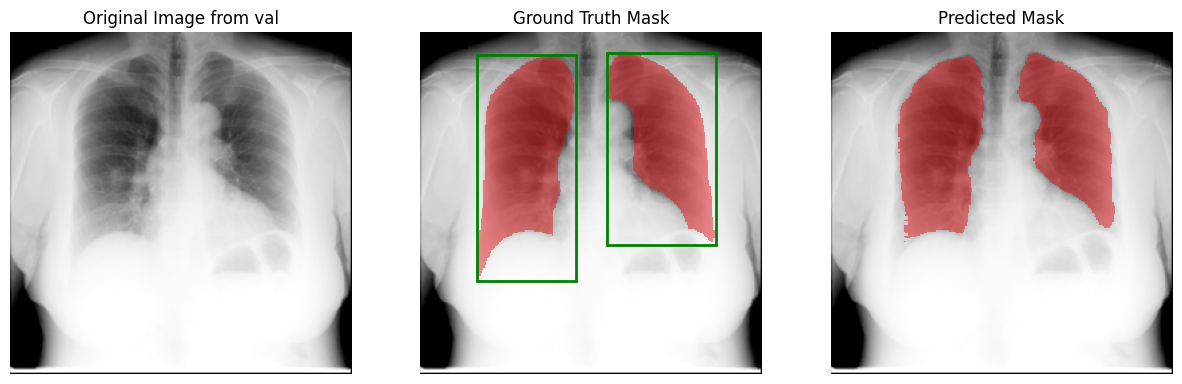

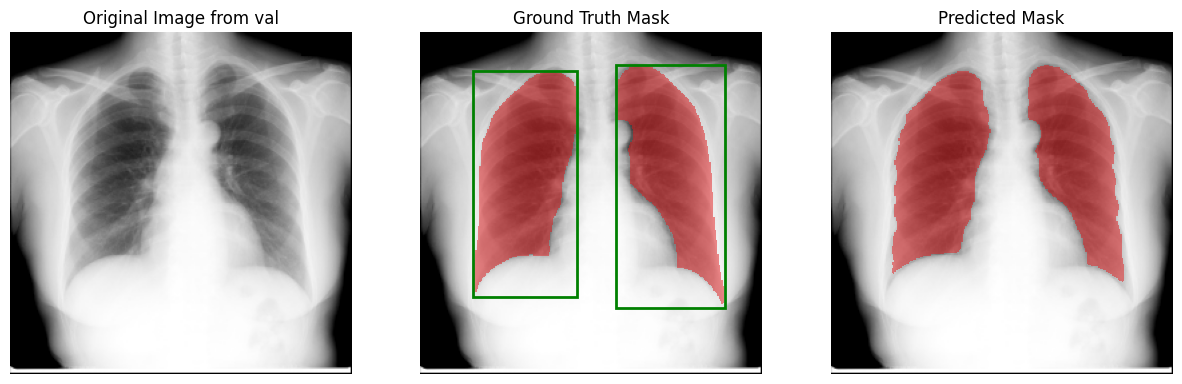

In [29]:
# Function to visualize the results
from matplotlib.colors import LinearSegmentedColormap
# blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["gray", "blue"])

def visualize_results(img, mask_gt, mask_pred, input_boxes):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img.squeeze(), cmap='gray')
    axs[0].set_title("Original Image from val")
    axs[0].axis('off')

    axs[1].imshow(img.squeeze(), cmap='gray')
    # show_mask(mask_gt, axs[1])
    mask = np.ma.masked_where(mask_gt == 0, mask_gt)
    axs[1].imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    for box in input_boxes:
        show_box(box, axs[1])
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis('off')

    axs[2].imshow(img.squeeze(), cmap='gray')
    # show_mask(mask_pred, axs[2])
    # mask = np.ma.masked_where(mask_gt == 0, mask_gt)
    # axs[2].imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    mask = np.ma.masked_where(mask_pred == 0, mask_pred)
    axs[2].imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    # for box in input_boxes:
    #     show_box(box, axs[2])
    axs[2].set_title("Predicted Mask")
    axs[2].axis('off')

    plt.show()

# Visualize the results for two example images
example_indices = [0, 1]  # You can choose any indices from the validation set

for idx in example_indices:
    img = x_val[idx]
    mask_gt = y_val[idx]
    bboxes = val_bounding_boxes[idx]

    # Set the image in the predictor
    predictor.set_image(img)

    combined_mask = np.zeros_like(mask_gt, dtype=bool)

    for box in bboxes:
        # Convert the single bounding box to numpy array
        input_box = np.array([box])

        # Predict masks using the bounding box as a prompt
        masks, scores, logits = predictor.predict(
            box=input_box,
            multimask_output=True,
        )

        # Select the best mask and predict again using the logits
        mask_input = logits[np.argmax(scores), :, :]
        masks, _, _ = predictor.predict(
            box=input_box,
            mask_input=mask_input[None, :, :],
            multimask_output=False,
        )

        # Combine the mask
        best_mask = masks[0]
        combined_mask = np.logical_or(combined_mask, best_mask)

    best_mask = torch.tensor(combined_mask, dtype=torch.int).to(device)

    # Normalize masks to binary values
    best_mask = (best_mask > 0).int().cpu().numpy()
    mask_gt = (torch.tensor(mask_gt, dtype=torch.int).to(device) > 0).int().cpu().numpy()

    # Visualize the results
    visualize_results(img, mask_gt, best_mask, bboxes)

# Object Detection Model to predict Bounding Boxes

In [44]:
# TODO: Implement an object detection model to find the left and right lung bounding boxes
import os
import shutil
from sklearn.model_selection import train_test_split

# Create directories for YOLOv8 dataset
dataset_path = 'lung_detection_dataset'
os.makedirs(f'{dataset_path}/images/train', exist_ok=True)
os.makedirs(f'{dataset_path}/images/val', exist_ok=True)
os.makedirs(f'{dataset_path}/images/test', exist_ok=True)
os.makedirs(f'{dataset_path}/labels/train', exist_ok=True)
os.makedirs(f'{dataset_path}/labels/val', exist_ok=True)
os.makedirs(f'{dataset_path}/labels/test', exist_ok=True)

def save_yolo_format(imgs, bboxes, split, prefix):
    for idx, (img, bbox) in enumerate(zip(imgs, bboxes)):
        img_path = f'{dataset_path}/images/{split}/{prefix}_{idx}.jpg'
        label_path = f'{dataset_path}/labels/{split}/{prefix}_{idx}.txt'

        # Save the image
        cv2.imwrite(img_path, img.squeeze())

        # Save the bounding boxes in YOLO format
        with open(label_path, 'w') as f:
            for box in bbox:
                x0, y0, x1, y1 = box
                x_center = (x0 + x1) / 2 / img.shape[1]
                y_center = (y0 + y1) / 2 / img.shape[0]
                width = (x1 - x0) / img.shape[1]
                height = (y1 - y0) / img.shape[0]
                f.write(f'0 {x_center} {y_center} {width} {height}\n')

# Split data into train, val, and test
train_imgs, val_test_imgs, train_bboxes, val_test_bboxes = train_test_split(x_train, train_bounding_boxes, test_size=0.2, random_state=42)
val_imgs, test_imgs, val_bboxes, test_bboxes = train_test_split(val_test_imgs, val_test_bboxes, test_size=0.5, random_state=42)

# Save train, val, and test sets
save_yolo_format(train_imgs, train_bboxes, 'train', 'train')
save_yolo_format(val_imgs, val_bboxes, 'val', 'val')
save_yolo_format(test_imgs, test_bboxes, 'test', 'test')

# Create data.yaml file
with open(f'{dataset_path}/data.yaml', 'w') as f:
    f.write(f"""
    train: /content/{dataset_path}/images/train
    val: /content/{dataset_path}/images/val
    test: /content/{dataset_path}/images/test
    nc: 1
    names: ['lung']
    """)

print("Dataset prepared for YOLOv8")

Dataset prepared for YOLOv8


In [32]:
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.6/780.6 kB 8.0 MB/s eta 0:00:00


In [77]:
from ultralytics import YOLO

# Initialize the YOLO model
model = YOLO('yolov8n.yaml')  # Use YOLOv8n model configuration

# Train the model
model.train(data=f'/content/{dataset_path}/data.yaml', epochs=250)

Ultralytics YOLOv8.2.32 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/lung_detection_dataset/data.yaml, epochs=250, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:205: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:210: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/lung_detection_dataset/labels/val.cache... 11 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11/11 [00:00<?, ?it/s]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train7
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      1/250      7.21G      3.496      3.364      4.171         43        640: 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22    0.00636      0.955     0.0308     0.0105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      2/250      5.04G      3.255      3.229      4.094         36        640: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22    0.00636      0.955     0.0366     0.0131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      3/250      5.04G      3.013      2.942      3.979         35        640: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22    0.00667          1     0.0743     0.0179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      4/250      5.04G       2.86      2.861      3.907         39        640: 100%|██████████| 6/6 [00:02<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22    0.00667          1     0.0451     0.0124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      5/250      5.04G      2.796      2.738      3.759         38        640: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22    0.00667          1     0.0667     0.0181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      6/250      5.04G      2.584      2.614      3.637         35        640: 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22    0.00667          1     0.0583     0.0207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      7/250      5.04G      2.486       2.45      3.493         45        640: 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22    0.00667          1     0.0629     0.0188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      8/250      5.04G      2.328      2.494      3.327         52        640: 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22    0.00667          1     0.0551     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      9/250      5.04G      2.218      2.281      3.165         35        640: 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22    0.00667          1      0.213     0.0507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     10/250      5.04G      2.276      2.335      3.191         43        640: 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22    0.00667          1       0.28     0.0661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     11/250      5.04G      2.194      2.346      3.165         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22     0.0298      0.955       0.18     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     12/250      5.04G      2.082      2.306      3.032         33        640: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22     0.0333      0.955       0.13     0.0254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     13/250      5.02G      2.089      2.147      2.859         37        640: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22     0.0452          1      0.103     0.0385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     14/250      5.02G      2.108       2.07      2.853         39        640: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.324      0.783      0.387      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     15/250      5.04G       2.11      2.078      2.767         37        640: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.462      0.743      0.614       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     16/250      5.04G      2.123      2.113       2.76         37        640: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.629      0.909      0.784      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     17/250      5.04G      1.971      1.888      2.672         33        640: 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.498      0.864      0.779      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     18/250      5.04G      1.965      1.827       2.66         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.746      0.934      0.907      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     19/250      5.02G      1.958      1.827      2.568         47        640: 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.673      0.749      0.784      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     20/250      5.02G      2.064      1.916       2.61         38        640: 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.663      0.909      0.814      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     21/250      5.04G       1.93      1.745      2.507         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.782      0.978      0.905      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     22/250      5.04G      1.821      1.792      2.412         46        640: 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.951      0.909      0.959      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     23/250      5.04G      1.909      1.818      2.543         38        640: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22       0.73      0.909      0.863      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     24/250      5.04G      1.865      1.691      2.416         38        640: 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.916      0.988      0.977      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     25/250      5.04G      1.852      1.758      2.434         36        640: 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.878      0.985       0.98      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     26/250      5.04G      1.839       1.71      2.372         46        640: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.712      0.864      0.896      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     27/250      5.04G       1.81      1.688      2.349         38        640: 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.776      0.955      0.907      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     28/250      5.02G      1.805       1.63      2.332         37        640: 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.757      0.727      0.835      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     29/250      5.04G      1.762      1.594        2.3         47        640: 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.796      0.864      0.912      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     30/250      5.04G      1.758      1.555       2.31         35        640: 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.911      0.909      0.986      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     31/250      5.04G      1.744      1.524      2.261         36        640: 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22          1      0.991      0.995       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     32/250      5.04G       1.67      1.434      2.151         40        640: 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22       0.98          1      0.995       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     33/250      5.04G      1.673      1.442      2.192         33        640: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.961      0.955      0.993      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     34/250      5.04G      1.695        1.4      2.164         39        640: 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.915          1      0.989      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     35/250      5.04G       1.65      1.333      2.184         37        640: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.993          1      0.995      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     36/250      5.04G      1.665      1.371      2.111         42        640: 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     37/250      5.04G      1.567      1.257      2.069         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.989          1      0.995      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     38/250      5.04G      1.552      1.258      2.059         42        640: 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     39/250      5.04G      1.656      1.291      2.145         34        640: 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     40/250      5.02G      1.565      1.264      2.085         36        640: 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     41/250      5.04G      1.641      1.196      2.069         47        640: 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.993          1      0.995      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     42/250      5.04G      1.585      1.246      2.061         43        640: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22       0.99          1      0.995      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     43/250      5.04G      1.482      1.176      2.022         44        640: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.987          1      0.995      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     44/250      5.02G      1.439      1.145      1.977         42        640: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.993          1      0.995      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     45/250      5.02G      1.418      1.134      1.997         39        640: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     46/250      5.04G      1.361      1.066      1.884         40        640: 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     47/250      5.04G      1.528      1.067          2         38        640: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22          1      0.989      0.995      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     48/250      5.04G       1.52      1.088      2.032         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.964          1      0.995      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     49/250      5.02G      1.492      1.055      2.016         32        640: 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     50/250      5.03G      1.542      1.095      2.051         46        640: 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994      0.955      0.992      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     51/250      5.04G      1.473      1.084       1.96         31        640: 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.992          1      0.995      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     52/250      5.04G      1.381      1.022      1.926         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.993          1      0.995      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     53/250      5.04G      1.399     0.9661      1.878         42        640: 100%|██████████| 6/6 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.992          1      0.995       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     54/250      5.04G      1.433     0.9475      1.911         37        640: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     55/250      5.04G      1.412     0.9773      1.886         42        640: 100%|██████████| 6/6 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     56/250      5.04G      1.324     0.9309      1.812         34        640: 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     57/250      5.04G      1.354     0.9444      1.864         46        640: 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     58/250      5.04G      1.314     0.9808      1.835         37        640: 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     59/250      5.04G      1.284     0.9295      1.846         26        640: 100%|██████████| 6/6 [00:01<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     60/250      5.04G      1.261     0.9084      1.791         43        640: 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     61/250      5.04G      1.231      0.893      1.773         37        640: 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     62/250      5.03G      1.224     0.9092      1.758         38        640: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     63/250      5.04G      1.251     0.8406      1.789         41        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     64/250      5.02G      1.284     0.8965      1.814         49        640: 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     65/250      5.04G      1.193     0.8617      1.697         38        640: 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     66/250      5.02G      1.193      0.823      1.723         44        640: 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     67/250      5.04G      1.175     0.8302      1.682         36        640: 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     68/250      5.04G      1.225     0.8621      1.772         47        640: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     69/250      5.04G      1.266      0.861      1.749         34        640: 100%|██████████| 6/6 [00:02<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     70/250      5.04G       1.17     0.8663      1.671         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     71/250      5.04G       1.32     0.9253      1.815         26        640: 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     72/250      5.04G       1.27     0.8548      1.806         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     73/250      5.04G      1.307      0.909      1.761         31        640: 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     74/250      5.04G      1.139     0.7987      1.681         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     75/250      5.04G       1.12     0.7988      1.678         34        640: 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     76/250      5.02G      1.176     0.7757      1.673         39        640: 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     77/250      5.04G      1.176     0.8213      1.681         45        640: 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     78/250      5.04G       1.14     0.7675      1.653         38        640: 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     79/250      5.04G      1.119      0.783      1.643         41        640: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     80/250      5.04G      1.099     0.7369      1.643         44        640: 100%|██████████| 6/6 [00:01<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     81/250      5.04G      1.101     0.7627      1.658         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     82/250      5.02G      1.127     0.7804      1.637         33        640: 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     83/250      5.04G      1.158     0.7862      1.647         50        640: 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     84/250      5.04G      1.138     0.7403      1.674         31        640: 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     85/250      5.04G      1.069     0.7181      1.595         43        640: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     86/250      5.04G      1.044     0.6995      1.585         39        640: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     87/250      5.04G      1.037     0.7144      1.569         31        640: 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     88/250      5.04G      1.058     0.7053      1.591         39        640: 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     89/250      5.04G      1.071     0.7031      1.606         39        640: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     90/250      5.04G      1.059     0.7271      1.593         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     91/250      5.04G      1.047     0.7448      1.588         33        640: 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     92/250      5.04G      1.033     0.7013      1.554         38        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     93/250      5.04G      1.011     0.6705      1.517         38        640: 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     94/250      5.04G      1.068     0.6876      1.568         47        640: 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     95/250      5.04G      1.064     0.7061      1.599         47        640: 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     96/250      5.04G     0.9307     0.6361      1.481         40        640: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     97/250      5.04G     0.9655     0.6585       1.48         52        640: 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     98/250      5.04G     0.9939      0.688      1.538         33        640: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     99/250      5.04G     0.9456     0.6463      1.523         40        640: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    100/250      5.04G      0.913     0.6291       1.45         41        640: 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    101/250      5.04G     0.9699     0.7038      1.538         35        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    102/250      5.04G     0.9535     0.6246      1.476         55        640: 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    103/250      5.02G     0.9994     0.6389      1.518         51        640: 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    104/250      5.02G     0.9901     0.6342      1.565         34        640: 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    105/250      5.04G     0.9766      0.641       1.52         38        640: 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    106/250      5.04G     0.9817     0.6178      1.535         39        640: 100%|██████████| 6/6 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    107/250      5.04G     0.9361      0.619      1.481         44        640: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    108/250      5.04G     0.9593      0.645      1.495         53        640: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.988      0.864      0.942      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    109/250      5.04G      1.001     0.6223      1.563         38        640: 100%|██████████| 6/6 [00:01<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22          1      0.719      0.925      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    110/250      5.04G      1.018     0.6125      1.525         47        640: 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    111/250      5.04G     0.9768     0.6184      1.495         44        640: 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    112/250      5.04G     0.9963     0.6313       1.54         51        640: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    113/250      5.02G     0.9718     0.6198      1.485         44        640: 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    114/250      5.04G     0.9156      0.629      1.493         42        640: 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    115/250      5.04G     0.8762     0.5914      1.438         37        640: 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    116/250      5.04G     0.8938     0.6096      1.443         38        640: 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    117/250      5.04G      0.853      0.567      1.419         37        640: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    118/250      5.04G     0.8882     0.5913       1.44         51        640: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    119/250      5.04G     0.8574     0.5777      1.431         41        640: 100%|██████████| 6/6 [00:01<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    120/250      5.02G     0.8811     0.5782      1.437         46        640: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    121/250      5.04G     0.9207     0.6162      1.464         43        640: 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    122/250      5.02G     0.8576     0.5669      1.422         42        640: 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    123/250      5.04G     0.8996     0.5953      1.469         49        640: 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    124/250      5.04G     0.8525     0.5681      1.422         44        640: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    125/250      5.04G     0.8673     0.5848      1.452         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    126/250      5.04G     0.8741     0.5943      1.422         30        640: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    127/250      5.04G     0.7984     0.5431      1.363         31        640: 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    128/250      5.04G     0.8327     0.5536      1.407         36        640: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    129/250      5.04G     0.8786     0.5685      1.447         46        640: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    130/250      5.04G     0.9107     0.5796      1.439         39        640: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    131/250      5.04G     0.9078     0.5736      1.446         53        640: 100%|██████████| 6/6 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    132/250      5.04G     0.8809     0.5845      1.423         33        640: 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    133/250      5.04G     0.8603     0.5674       1.41         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    134/250      5.04G     0.8366     0.5395      1.388         48        640: 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    135/250      5.04G     0.8178     0.5315      1.364         31        640: 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    136/250      5.04G     0.8099     0.5268      1.378         34        640: 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    137/250      5.02G     0.8457     0.5602      1.421         41        640: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    138/250      5.02G     0.8918     0.5528       1.43         39        640: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    139/250      5.04G     0.8668     0.5729      1.419         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    140/250      5.02G     0.8564     0.5619      1.405         47        640: 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    141/250      5.04G     0.8398      0.545      1.393         35        640: 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    142/250      5.04G      0.839     0.5503      1.374         35        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    143/250      5.04G     0.8282     0.5513       1.38         47        640: 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    144/250      5.04G     0.8367     0.5655      1.395         53        640: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    145/250      5.04G      0.797     0.5106      1.348         37        640: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    146/250      5.04G     0.8606     0.5701      1.388         43        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    147/250      5.04G     0.7504     0.5117       1.31         37        640: 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    148/250      5.04G      0.805     0.5325      1.401         45        640: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    149/250      5.04G     0.8139     0.5415      1.377         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    150/250      5.02G     0.7894      0.522      1.356         35        640: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    151/250      5.04G     0.8218     0.5387      1.366         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    152/250      5.02G      0.802     0.5366      1.355         41        640: 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    153/250      5.04G     0.8323     0.5169      1.387         54        640: 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    154/250      5.04G     0.7463       0.49      1.301         42        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    155/250      5.02G     0.8038     0.5061      1.354         43        640: 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    156/250      5.04G     0.8564     0.5334      1.404         42        640: 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    157/250      5.04G     0.8482     0.5537      1.385         38        640: 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    158/250      5.04G     0.7958     0.5365      1.362         33        640: 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    159/250      5.04G     0.8027     0.5073      1.357         37        640: 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    160/250      5.04G     0.8307     0.5552      1.405         34        640: 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    161/250      5.04G      0.801     0.5337      1.373         35        640: 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    162/250      5.04G      0.807     0.5212      1.355         45        640: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    163/250      5.04G     0.7667     0.4944       1.31         47        640: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    164/250      5.04G     0.7669     0.4897      1.312         34        640: 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    165/250      5.04G     0.7927     0.5007      1.372         38        640: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    166/250      5.04G     0.7372     0.4665      1.304         44        640: 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    167/250      5.04G     0.7087     0.4673        1.3         37        640: 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    168/250      5.04G     0.7395     0.4922      1.309         42        640: 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    169/250      5.04G     0.7722     0.4749      1.335         44        640: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    170/250      5.04G      0.731     0.4776      1.302         46        640: 100%|██████████| 6/6 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    171/250      5.04G      0.746     0.4917      1.332         41        640: 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    172/250      5.02G     0.7484     0.4915      1.339         31        640: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    173/250      5.04G     0.7574     0.4855      1.307         38        640: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    174/250      5.02G     0.7638     0.5214      1.334         25        640: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    175/250      5.04G     0.7648     0.5011      1.313         26        640: 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    176/250      5.04G     0.7628     0.5403      1.338         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.998          1      0.995      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    177/250      5.04G     0.7363     0.4984      1.327         37        640: 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    178/250      5.04G     0.7456     0.4991      1.316         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    179/250      5.04G     0.7877     0.5223      1.382         33        640: 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    180/250      5.04G     0.6833     0.4406      1.286         36        640: 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    181/250      5.04G     0.7198     0.4711      1.324         25        640: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    182/250      5.02G     0.7185     0.4653      1.302         36        640: 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    183/250      5.04G     0.7585     0.4852      1.306         35        640: 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    184/250      5.04G      0.758     0.4913      1.349         38        640: 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    185/250      5.04G      0.703     0.4752      1.272         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    186/250      5.04G     0.7098     0.4613      1.292         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    187/250      5.04G     0.7118     0.4497      1.267         41        640: 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    188/250      5.04G     0.6981     0.4756      1.324         31        640: 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    189/250      5.04G     0.6933     0.4708       1.26         34        640: 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    190/250      5.04G     0.6942     0.4538      1.294         34        640: 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    191/250      5.04G     0.7179      0.465      1.272         45        640: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    192/250      5.04G     0.6374     0.4411      1.256         36        640: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    193/250      5.04G     0.6876     0.4722       1.29         42        640: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    194/250      5.02G     0.7228     0.4773        1.3         48        640: 100%|██████████| 6/6 [00:01<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    195/250      5.04G     0.6976     0.4591      1.296         39        640: 100%|██████████| 6/6 [00:01<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    196/250      5.04G     0.7222     0.4699      1.271         32        640: 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    197/250      5.04G     0.7051     0.4631      1.291         32        640: 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    198/250      5.04G     0.6618      0.449      1.286         38        640: 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    199/250      5.04G     0.7438     0.4859      1.297         37        640: 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    200/250      5.04G     0.7534     0.5014      1.315         31        640: 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    201/250      5.04G     0.6784     0.4398      1.261         37        640: 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    202/250      5.04G     0.6531     0.4375      1.238         37        640: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    203/250      5.04G     0.7477     0.4766      1.295         48        640: 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    204/250      5.02G     0.7193     0.4806      1.304         44        640: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    205/250      5.04G     0.7129     0.4707      1.292         43        640: 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    206/250      5.04G     0.6739     0.4524      1.285         35        640: 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    207/250      5.04G      0.665     0.4523       1.25         41        640: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    208/250      5.04G     0.6536     0.4377      1.252         35        640: 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    209/250      5.02G      0.706     0.4513      1.265         46        640: 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    210/250      5.04G     0.6808     0.4555      1.266         38        640: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    211/250      5.04G      0.641     0.4159      1.241         38        640: 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.994          1      0.995      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    212/250      5.04G     0.6908     0.4429      1.268         41        640: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    213/250      5.04G     0.6668     0.4501      1.247         43        640: 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.995          1      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    214/250      5.04G     0.6523     0.4318       1.22         35        640: 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    215/250      5.04G      0.718     0.4687      1.313         39        640: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    216/250      5.04G     0.6548     0.4182      1.251         34        640: 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    217/250      5.02G     0.6723     0.4546       1.26         43        640: 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    218/250      5.04G     0.6788     0.4422      1.265         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    219/250      5.04G     0.6433     0.4274      1.264         37        640: 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    220/250      5.04G     0.7056     0.4424      1.289         43        640: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    221/250      5.04G     0.6716     0.4345      1.267         48        640: 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    222/250      5.04G     0.6803       0.43      1.267         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    223/250      5.04G     0.6338     0.4225      1.219         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    224/250      5.04G      0.691     0.4468      1.275         33        640: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    225/250      5.04G     0.7092      0.445      1.261         38        640: 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    226/250      5.04G     0.6526     0.4164      1.244         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    227/250      5.04G     0.6263      0.423      1.224         41        640: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    228/250      5.04G     0.6584     0.4309      1.245         40        640: 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.996          1      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    229/250      5.04G     0.6653     0.4274      1.246         42        640: 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    230/250      5.04G     0.6289     0.4201      1.237         36        640: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    231/250      5.04G      0.672     0.4316      1.275         42        640: 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    232/250      5.02G      0.662     0.4223      1.259         39        640: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    233/250      5.04G     0.6222      0.433      1.236         50        640: 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    234/250      5.04G     0.6429     0.4203       1.21         30        640: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    235/250      5.04G     0.6417      0.435      1.252         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    236/250      5.04G     0.6343     0.4208      1.227         34        640: 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    237/250      5.04G     0.6866     0.4459      1.282         34        640: 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    238/250      5.04G     0.6559      0.431      1.286         39        640: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    239/250      5.04G     0.6576     0.4471      1.287         34        640: 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    240/250      5.02G     0.6139      0.422      1.225         39        640: 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.946


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    241/250       5.2G     0.4789     0.3694      1.088         18        640: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    242/250      5.02G     0.6478     0.5289      1.329         18        640: 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    243/250      5.02G     0.4903     0.3858      1.149         18        640: 100%|██████████| 6/6 [00:01<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    244/250      5.02G     0.4737     0.3767      1.151         18        640: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    245/250      5.02G     0.4728     0.3569      1.153         18        640: 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    246/250      5.02G     0.4524     0.3286       1.09         18        640: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    247/250      5.02G     0.4473     0.3342       1.11         18        640: 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    248/250      5.02G     0.4309     0.3321      1.086         18        640: 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    249/250      5.02G     0.4383     0.3324      1.126         18        640: 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    250/250      5.02G     0.4317     0.3239      1.073         18        640: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP

                   all         11         22      0.997          1      0.995      0.936



250 epochs completed in 0.218 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 6.3MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.2.32 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:205: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:210: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


                   all         11         22      0.997          1      0.995      0.952
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train7


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7868abc78520>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [78]:
# from ultralytics import YOLO

# Locate the correct path for the best model checkpoint
runs_detect_path = 'runs/detect'
best_model_path = None
for root, dirs, files in os.walk(runs_detect_path):
    for file_name in files:
        if file_name == 'best.pt':
            best_model_path = os.path.join(root, file_name)
            print(f'Found best model checkpoint at: {best_model_path}')
            break

if not best_model_path:
    raise FileNotFoundError("Best model checkpoint not found.")

# Load the best model
model = YOLO(best_model_path)

# Evaluate the model on the test set
results = model.val(data=f'{dataset_path}/data.yaml', split='test')

# Print evaluation results
print(results)

Found best model checkpoint at: runs/detect/train7/weights/best.pt
Found best model checkpoint at: runs/detect/train/weights/best.pt
Found best model checkpoint at: runs/detect/train5/weights/best.pt
Found best model checkpoint at: runs/detect/train2/weights/best.pt
Found best model checkpoint at: runs/detect/train6/weights/best.pt
Found best model checkpoint at: runs/detect/train3/weights/best.pt
Found best model checkpoint at: runs/detect/train4/weights/best.pt
Ultralytics YOLOv8.2.32 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:205: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:210: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

                   all         12         24      0.995          1      0.995       0.91
Speed: 0.3ms preprocess, 5.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val7
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7868abef3bb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03303

In [79]:
# Predict bounding boxes on the test set
test_bboxes_pred = []
iou_scores = []

for img, gt_bboxes in zip(x_test, test_bounding_boxes):
    results = model(img)
    # Extract predictions from the results
    for result in results:
        # Get bounding boxes in (x0, y0, x1, y1) format
        pred_bboxes = result.boxes.xyxy.cpu().numpy()
        test_bboxes_pred.append(pred_bboxes)

        # Calculate IoU for each predicted box with ground truth
        iou_per_image = []
        for box_pred in pred_bboxes:
            x0, y0, x1, y1 = box_pred
            iou_per_box = []
            for box_gt in gt_bboxes:
                if len(box_gt) != 4:
                    continue
                x0_gt, y0_gt, x1_gt, y1_gt = box_gt
                xi1 = max(x0, x0_gt)
                yi1 = max(y0, y0_gt)
                xi2 = min(x1, x1_gt)
                yi2 = min(y1, y1_gt)
                inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
                box_area = (x1 - x0) * (y1 - y0)
                box_gt_area = (x1_gt - x0_gt) * (y1_gt - y0_gt)
                union_area = box_area + box_gt_area - inter_area
                iou = inter_area / union_area
                iou_per_box.append(iou)
            if iou_per_box:
                iou_per_image.append(max(iou_per_box))
        if iou_per_image:
            iou_scores.append(np.mean(iou_per_image))

mean_iou = np.mean(iou_scores)
print(f"Mean IoU on the test set: {mean_iou:.4f}")


0: 640x640 2 lungs, 19.9ms
Speed: 3.4ms preprocess, 19.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 18.6ms
Speed: 3.6ms preprocess, 18.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 20.7ms
Speed: 4.4ms preprocess, 20.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 11.9ms
Speed: 5.5ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 18.9ms
Speed: 2.9ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 64

In [80]:
import torchmetrics
import numpy as np
import torch

# Predict bounding boxes on the test set
test_bboxes_pred = []
for img in x_test:
    results = model(img)
    # Extract predictions from the results
    for result in results:
        # Get bounding boxes in (x0, y0, x1, y1) format
        bboxes = result.boxes.xyxy.cpu().numpy()
        test_bboxes_pred.append(bboxes)

# Initialize F1 metric
f1 = torchmetrics.F1Score(task="binary").to(device)

# Evaluate SAM with predicted bounding boxes
f1_scores_pred_bboxes = []

for img, mask_gt, bboxes in zip(x_test, y_test, test_bboxes_pred):
    # Set the image in the predictor
    predictor.set_image(img)

    combined_mask = np.zeros_like(mask_gt, dtype=bool)

    for box in bboxes:
        # Convert the single bounding box to numpy array
        input_box = np.array([box])

        # Predict masks using the bounding box as a prompt
        masks, scores, logits = predictor.predict(
            box=input_box,
            multimask_output=True,
        )

        # Select the best mask and predict again using the logits
        mask_input = logits[np.argmax(scores), :, :]
        masks, _, _ = predictor.predict(
            box=input_box,
            mask_input=mask_input[None, :, :],
            multimask_output=False,
        )

        # Combine the mask
        best_mask = masks[0]
        combined_mask = np.logical_or(combined_mask, best_mask)

    best_mask = torch.tensor(combined_mask, dtype=torch.int).to(device)

    # Normalize masks to binary values
    best_mask = (best_mask > 0).int()
    mask_gt = (torch.tensor(mask_gt, dtype=torch.int).to(device) > 0).int()

    # Compute F1 score
    f1_scores_pred_bboxes.append(f1(best_mask.flatten(), mask_gt.flatten()).item())

mean_f1_pred_bboxes = np.mean(f1_scores_pred_bboxes)
std_f1_pred_bboxes = np.std(f1_scores_pred_bboxes)

print(f"Mean F1 score with predicted bounding boxes: {mean_f1_pred_bboxes:.4f}")
print(f"Standard deviation: {std_f1_pred_bboxes:.4f}")


0: 640x640 2 lungs, 9.7ms
Speed: 2.6ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 17.3ms
Speed: 8.1ms preprocess, 17.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 16.7ms
Speed: 4.9ms preprocess, 16.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 11.5ms
Speed: 4.7ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 16.9ms
Speed: 2.7ms preprocess, 16.9ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 13.2ms
Speed: 4.4ms preprocess, 13.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 lungs, 12.6ms
Speed: 3.3ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 

/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/image_encoder.py:231: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  attn = (q * self.scale) @ k.transpose(-2, -1)
/usr/local/lib/python3.10/dist-packages/torch/functional.py:385: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because i

Mean F1 score with predicted bounding boxes: 0.9233
Standard deviation: 0.0280


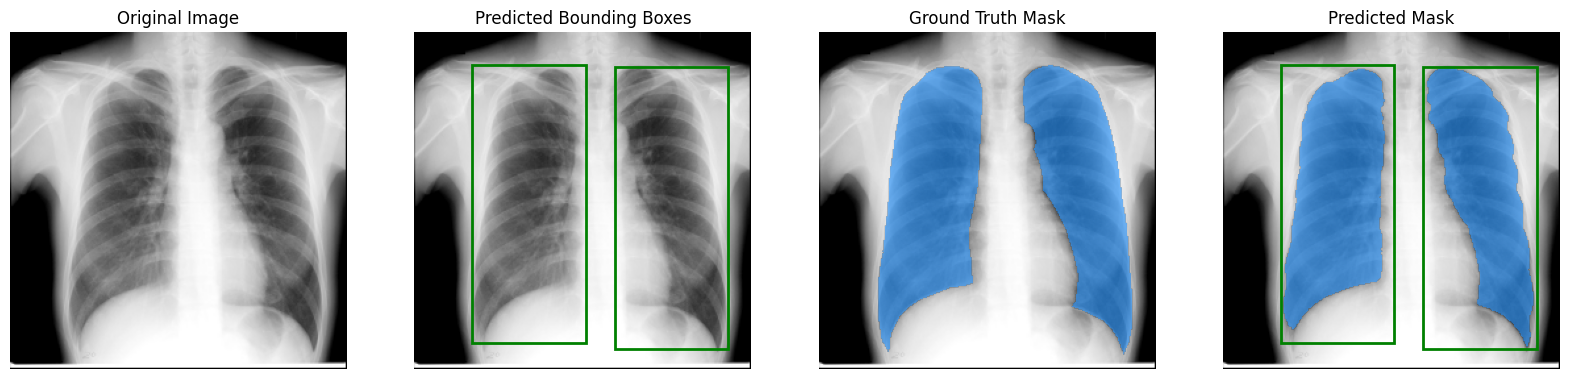

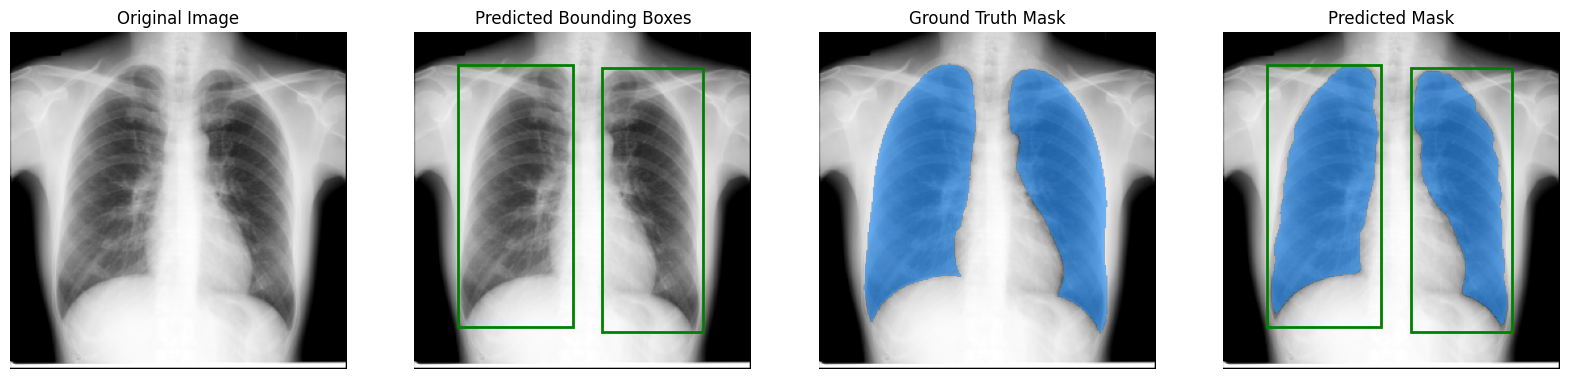

In [81]:
import matplotlib.pyplot as plt

# Function to visualize the results
def visualize_results(img, mask_gt, mask_pred, input_boxes):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(img.squeeze(), cmap='gray')
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(img.squeeze(), cmap='gray')
    for box in input_boxes:
        show_box(box, axs[1])
    axs[1].set_title("Predicted Bounding Boxes")
    axs[1].axis('off')

    axs[2].imshow(img.squeeze(), cmap='gray')
    show_mask(mask_gt, axs[2])
    axs[2].set_title("Ground Truth Mask")
    axs[2].axis('off')

    axs[3].imshow(img.squeeze(), cmap='gray')
    show_mask(mask_pred, axs[3])
    for box in input_boxes:
        show_box(box, axs[3])
    axs[3].set_title("Predicted Mask")
    axs[3].axis('off')

    plt.show()

# Visualize the results for two example images
example_indices = [0, 1]  # You can choose any indices from the test set

for idx in example_indices:
    img = x_test[idx]
    mask_gt = y_test[idx]
    bboxes = test_bboxes_pred[idx]

    # Set the image in the predictor
    predictor.set_image(img)

    combined_mask = np.zeros_like(mask_gt, dtype=bool)

    for box in bboxes:
        # Convert the single bounding box to numpy array
        input_box = np.array([box])

        # Predict masks using the bounding box as a prompt
        masks, scores, logits = predictor.predict(
            box=input_box,
            multimask_output=True,
        )

        # Select the best mask and predict again using the logits
        mask_input = logits[np.argmax(scores), :, :]
        masks, _, _ = predictor.predict(
            box=input_box,
            mask_input=mask_input[None, :, :],
            multimask_output=False,
        )

        # Combine the mask
        best_mask = masks[0]
        combined_mask = np.logical_or(combined_mask, best_mask)

    best_mask = torch.tensor(combined_mask, dtype=torch.int).to(device)

    # Normalize masks to binary values
    best_mask = (best_mask > 0).int().cpu().numpy()
    mask_gt = (torch.tensor(mask_gt, dtype=torch.int).to(device) > 0).int().cpu().numpy()

    # Visualize the results
    visualize_results(img, mask_gt, best_mask, bboxes)